# Data processing for bump hunt

Main differences for bump hunt:
- No fully supervised set
- test set covers the whole SR / SB range



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
import os

from helpers.plotting import *
from helpers.physics_functions import *
from helpers.data_transforms import *

plt.style.use("../science.mplstyle")


In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file)

In [3]:
project_id = "lowmass"
run_id = "trigger_12_03"
run_jet = False

working_dir = workflow["file_paths"]["working_dir"]
path_to_compiled_data = workflow["file_paths"]["data_storage_dir"]+f"/compiled_data/{project_id}"
    
codes_list = ["skimmed_data_2016H_30555_nojet"] # may want multiple codes for injection studies

uncut_data_OS, uncut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    with open(f"{path_to_compiled_data}/{code}", "rb") as ifile:
        tmp_dict = pickle.load(ifile)
        for key in tmp_dict.keys():
            if "samesign" in key:
                uncut_data_SS[code][key[:-9]] = tmp_dict[key]
            else:
                uncut_data_OS[code][key] = tmp_dict[key]
        
    
    print(code, "opp sign",  uncut_data_OS[code][list(uncut_data_OS[code].keys())[0]].shape)
    print(code, "same sign", uncut_data_SS[code][list(uncut_data_SS[code].keys())[0]].shape)

skimmed_data_2016H_30555_nojet opp sign (21803678,)
skimmed_data_2016H_30555_nojet same sign (6756613,)


In [4]:
feature_set = list(uncut_data_OS[codes_list[0]].keys())
feature_set = [x for x in feature_set if "HLT" not in x]
print(feature_set)

['dimu_pt', 'dimu_eta', 'dimu_phi', 'n_muons', 'n_jets', 'dimu_mass', 'mu0_ip3d', 'mu1_ip3d', 'mu0_jetiso', 'mu1_jetiso', 'mu0_eta', 'mu1_eta', 'mu0_pt', 'mu1_pt', 'mu0_phi', 'mu1_phi', 'mu0_iso04', 'mu1_iso04', 'mumu_deltaR', 'mumu_deltapT']


## Make cuts

Now let's define cuts on the data. 

Muon cuts were made previously (and we don't want to make cuts on the dimuon system, either)


In [5]:
#particle = "upsilon"
#analysis_test_id = "iso"

particle = "eta"
analysis_test_id = "none"
processed_data_dir = workflow["file_paths"]["data_storage_dir"] +f"/projects/{run_id}/processed_data/"
os.makedirs(processed_data_dir, exist_ok = True)


SB_left = float(workflow["window_definitions"][particle]["SB_left"])
SR_left = float(workflow["window_definitions"][particle]["SR_left"])
SR_right = float(workflow["window_definitions"][particle]["SR_right"])
SB_right = float(workflow["window_definitions"][particle]["SB_right"])


band_bounds = {"SBL": [SB_left,SR_left],
                   "SR": [SR_left,SR_right],
                   "SBH": [SR_right,SB_right],
                           }

print(band_bounds)

if particle == "upsilon":
    iso_cut = 0.55
elif particle == "eta":
    iso_cut = 0
pt_high_cut, pt_low_cut = 17, 8
trigger = "HLT_TrkMu15_DoubleTrkMu5NoFiltersNoVtx"
#N_test = 25000
#random_seed = 4 # 2.5 for cubic


cut_data_OS, cut_data_SS = {code:{} for code in codes_list},  {code:{} for code in codes_list}

for code in codes_list:
    
    
    # define cuts

    pass_indices_OS = (uncut_data_OS[code]["mu0_iso04"] >= iso_cut) & (uncut_data_OS[code]["mu1_iso04"] >= iso_cut) & (uncut_data_OS[code]["mu0_pt"] >= pt_high_cut) & (uncut_data_OS[code]["mu1_pt"] >= pt_low_cut) & (uncut_data_OS[code]["dimu_mass"] >= SB_left) & (uncut_data_OS[code]["dimu_mass"] <= SB_right) & (uncut_data_OS[code][trigger])
    pass_indices_SS = (uncut_data_SS[code]["mu0_iso04"] >= iso_cut) & (uncut_data_SS[code]["mu1_iso04"] >= iso_cut) & (uncut_data_SS[code]["mu0_pt"] >= pt_high_cut) & (uncut_data_SS[code]["mu1_pt"] >= pt_low_cut) & (uncut_data_SS[code]["dimu_mass"] >= SB_left) & (uncut_data_SS[code]["dimu_mass"] <= SB_right) & (uncut_data_SS[code][trigger])

    # apply cuts to oppsign
    for feat in feature_set:
        cut_data_OS[code][feat] = uncut_data_OS[code][feat][pass_indices_OS]
        cut_data_SS[code][feat] = uncut_data_SS[code][feat][pass_indices_SS]
    
    print(f"{code} OS has shape {cut_data_OS[code][feat].shape} after cuts")
    print(f"{code} SS has shape {cut_data_SS[code][feat].shape} after cuts")
    
    


{'SBL': [0.3, 0.525], 'SR': [0.525, 0.569], 'SBH': [0.569, 0.72]}
skimmed_data_2016H_30555_nojet OS has shape (12468,) after cuts
skimmed_data_2016H_30555_nojet SS has shape (755,) after cuts


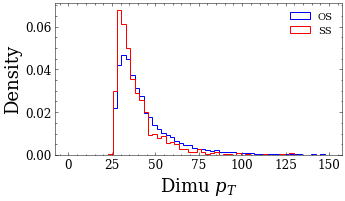

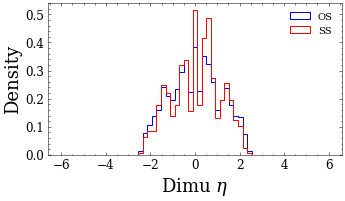

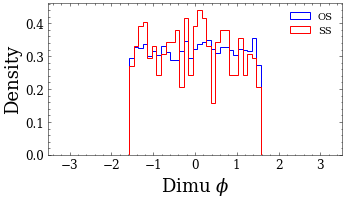

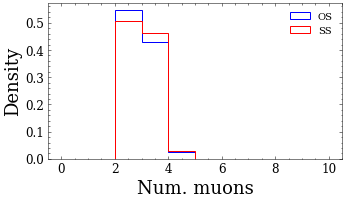

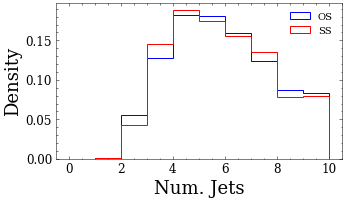

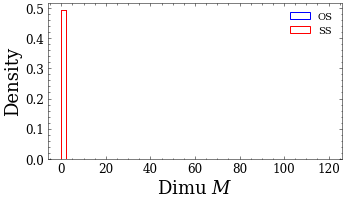

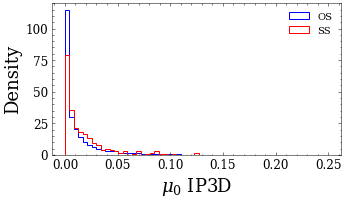

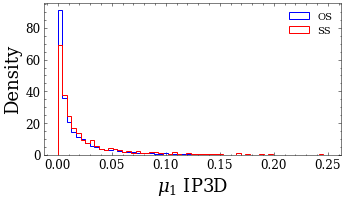

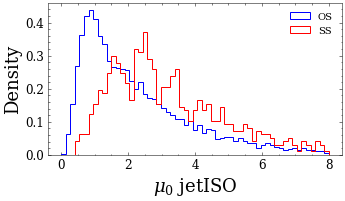

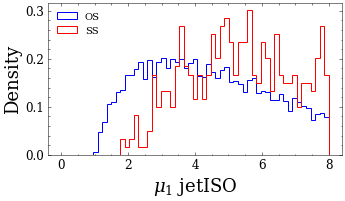

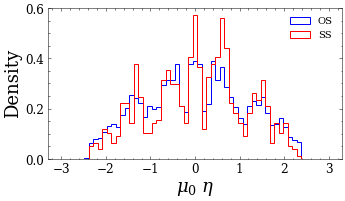

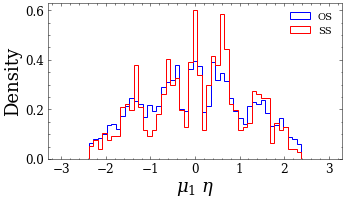

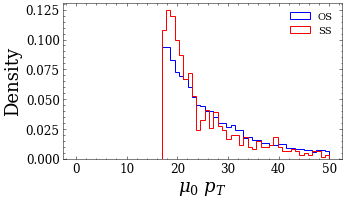

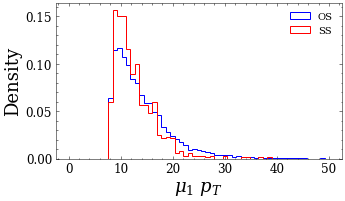

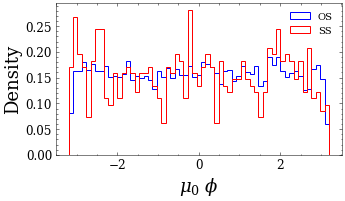

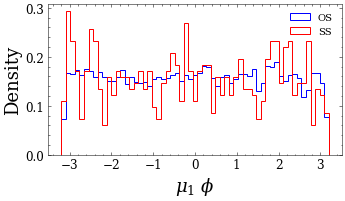

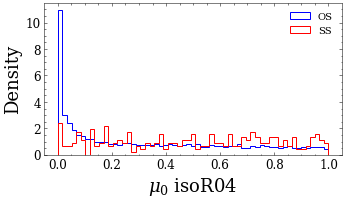

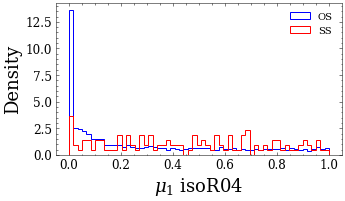

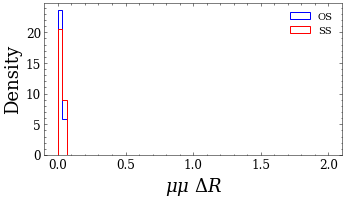

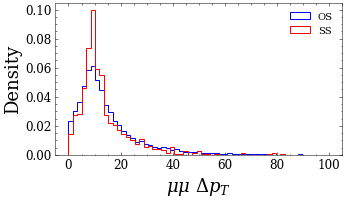

In [6]:
kwargs_dict_dtype = {"OS":{"density": True, "histtype": "step", "color":"blue", "label": "OS"},
                    "SS":{"density": True, "histtype": "step", "color":"red", "label": "SS"}}
        
hist_all_features_dict([cut_data_OS[codes_list[0]], cut_data_SS[codes_list[0]]], ["OS", "SS"], feature_set, kwargs_dict_dtype, nice_labels=True)


Check how local cuts affect the starting significance

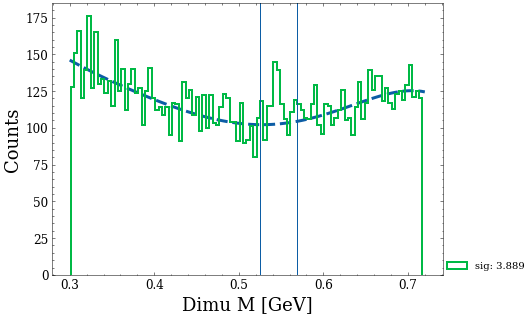

In [7]:
bkg_fit_type = "quintic"
num_bins_SR = 12
bkg_fit_function = bkg_fit_quintic
plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR= num_bins_SR)

x = np.linspace(SB_left, SB_right, 100) # plot curve fit

plt.figure(figsize = (7,5))

# plot all data
popt_0, pcov_0, _, _, _ = curve_fit_m_inv(cut_data_OS[code]["dimu_mass"], bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)

plt.plot(x, bkg_fit_function(x, *popt_0), lw = 3, linestyle = "dashed")
sig = np.sqrt(calculate_test_statistic(cut_data_OS[code]["dimu_mass"], bkg_fit_function, bkg_fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt_0, pcov_0))

plt.hist(cut_data_OS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = False, label = f"sig: {round(sig,3)}")

plt.axvline(SR_left)
plt.axvline(SR_right)

plt.xlabel("Dimu M [GeV]")
plt.ylabel("Counts")
plt.legend(loc = (1, 0))

plt.show()


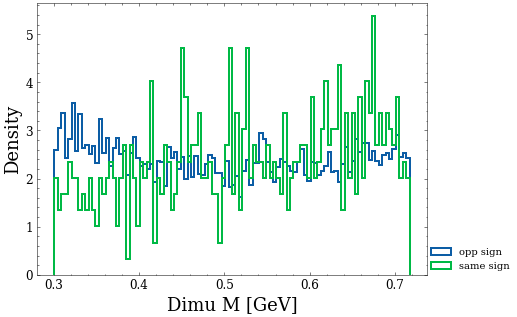

In [8]:

plt.figure(figsize = (7,5))

# plot all data
plt.hist(cut_data_OS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"opp sign")
plt.hist(cut_data_SS[code]["dimu_mass"], bins = plot_bins_all, lw = 2, histtype = "step", density = True, label = f"same sign")
plt.xlabel("Dimu M [GeV]")
plt.ylabel("Density")
plt.legend(loc = (1, 0))
plt.show()
 


Split data into bands

In [9]:
bands = ["SBL", "SR", "SBH"]
N_total_events_OS = 0
N_total_events_SS = 0


preproc_dicts_OS, preproc_dicts_SS = {b:{} for b in bands}, {b:{} for b in bands}


for code in codes_list:
    for b in bands:

        # opp sign
        loc_pass_indices_OS = (cut_data_OS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_OS[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_OS[b][code] = {}
        for feat in feature_set:
            preproc_dicts_OS[b][code][feat] = cut_data_OS[code][feat][loc_pass_indices_OS]
            
       
        N_total_events_OS += preproc_dicts_OS[b][code][feat].shape[0]
        
        # same sign
        loc_pass_indices_SS = (cut_data_SS[code]["dimu_mass"] >= band_bounds[b][0]) & (cut_data_SS[code]["dimu_mass"] < band_bounds[b][1])
        preproc_dicts_SS[b][code] = {}
        for feat in feature_set:
            preproc_dicts_SS[b][code][feat] = cut_data_SS[code][feat][loc_pass_indices_SS]
            
        N_total_events_SS += preproc_dicts_SS[b][code][feat].shape[0]
  
    
    
print(f"Total events opp sign: {N_total_events_OS}")
print(f"Total events same sign: {N_total_events_SS}")
    

Total events opp sign: 12468
Total events same sign: 755


## Preprocessing

Standard scaling is fine

In [10]:
from sklearn.preprocessing import StandardScaler

sizes_dict_OS, sizes_dict_SS = {}, {}

preprocessing_info = {}
proccessed_data_dict_OS, proccessed_data_dict_SS  = {b:{"s_inj_data":{}} for b in bands}, {b:{"s_inj_data":{}} for b in bands}

for feat in feature_set: 
    
    # train the preprocessor on the opp sign data only
    data_SB = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat])).reshape(-1, 1)
    
    if feat == "dimu_mass": # don't logit transform
        mass_scaler = StandardScaler()
        mass_scaler = mass_scaler.fit(data_SB)
      
        with open(f"{processed_data_dir}/mass_scaler_{particle}_{analysis_test_id}", "wb") as ofile:
            pickle.dump(mass_scaler, ofile)
        
        for b in bands:
            proccessed_data_dict_OS[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts_OS[b][code][feat].reshape(-1,1))
            proccessed_data_dict_SS[b]["s_inj_data"][feat] = mass_scaler.transform(preproc_dicts_SS[b][code][feat].reshape(-1,1))
            sizes_dict_OS[b] = proccessed_data_dict_OS[b]["s_inj_data"][feat].shape[0]
            sizes_dict_SS[b] = proccessed_data_dict_SS[b]["s_inj_data"][feat].shape[0]
    
    else:   
        data_all = np.hstack((preproc_dicts_OS["SBL"][code][feat], preproc_dicts_OS["SBH"][code][feat], preproc_dicts_OS["SR"][code][feat])).reshape(-1, 1)
        all_min = np.min(data_all)
        all_max = np.max(data_all)
        # logit transform the features   
    
        transformed_feats = logit_transform(data_SB, all_min, all_max)
        # subtract off mean, std of the training set
        mean_to_sub = np.mean(transformed_feats)
        std_to_sub = np.std(transformed_feats)
        
        preprocessing_info[feat] = {"mean":mean_to_sub, "std":std_to_sub, "min":all_min, "max":all_max}
        
        for b in bands:
            proccessed_data_dict_OS[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_OS[b][code][feat], all_min, all_max) - mean_to_sub)/std_to_sub
            proccessed_data_dict_SS[b]["s_inj_data"][feat] = (logit_transform(preproc_dicts_SS[b][code][feat], all_min, all_max) - mean_to_sub)/std_to_sub

with open(f"{processed_data_dir}/preprocessing_info_{particle}_{analysis_test_id}", "wb") as ofile:
            pickle.dump(preprocessing_info, ofile)

   

/global/u1/r/rmastand/dimuonAD/helpers/data_transforms.py:10: RuntimeWarning: invalid value encountered in log
  logit = np.log(x_norm/(1.0-x_norm+epsilon)+epsilon)


In [11]:
print(sizes_dict_OS)
print(sizes_dict_SS)

{'SBL': 6739, 'SR': 1271, 'SBH': 4458}
{'SBL': 352, 'SR': 80, 'SBH': 323}


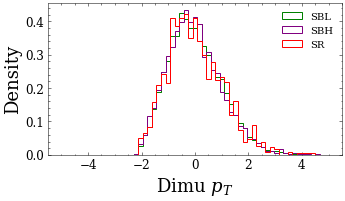

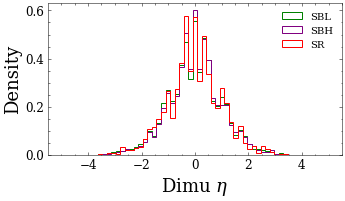

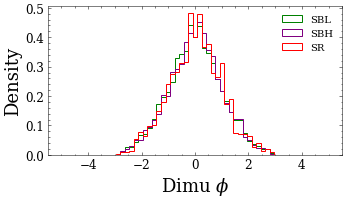

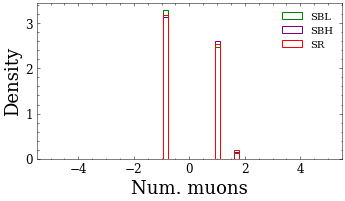

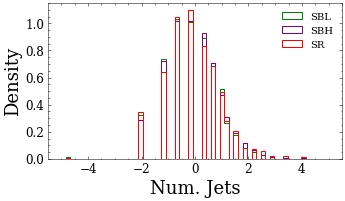

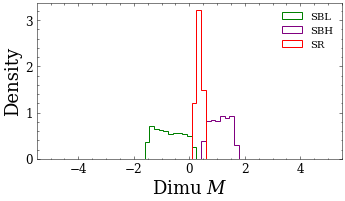

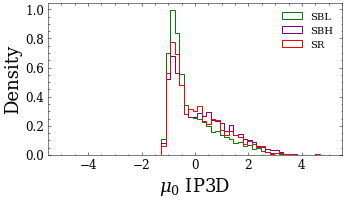

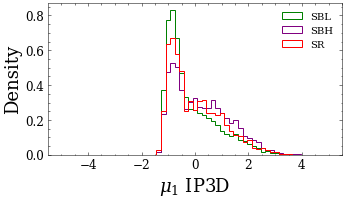

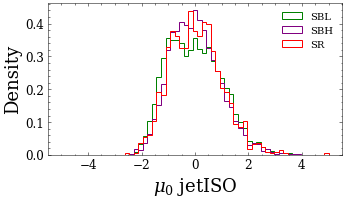

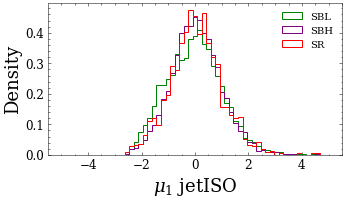

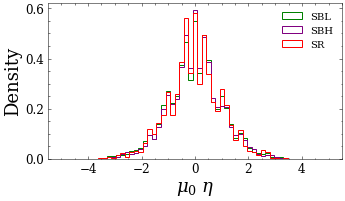

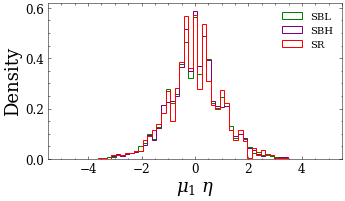

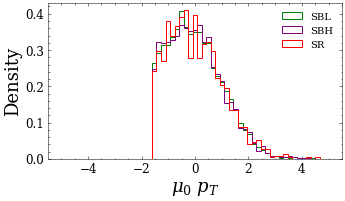

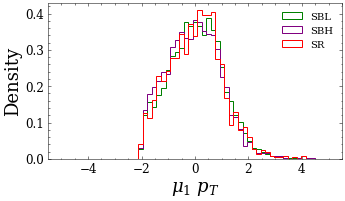

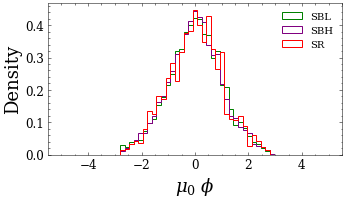

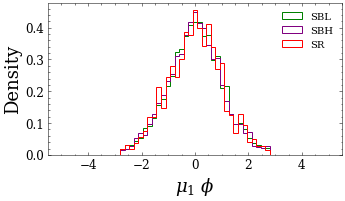

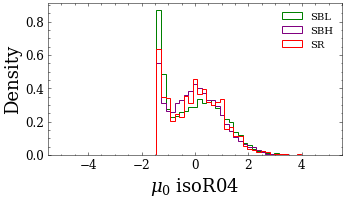

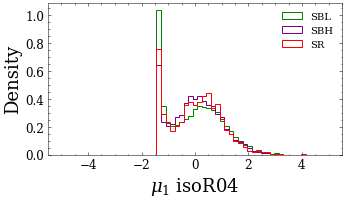

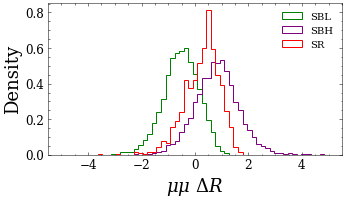

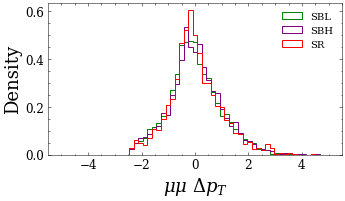

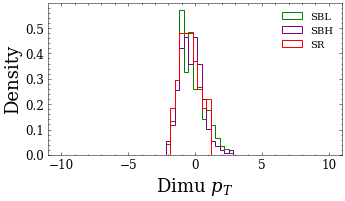

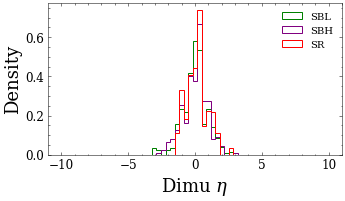

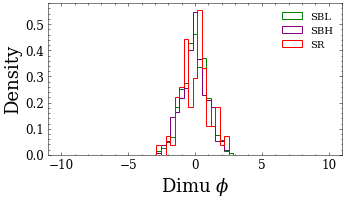

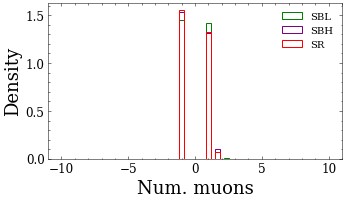

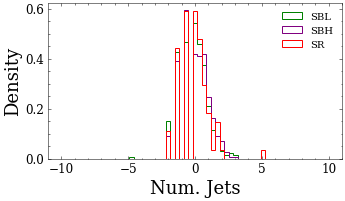

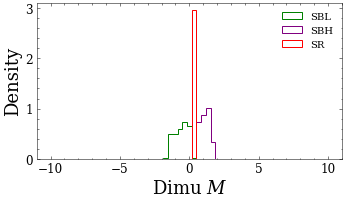

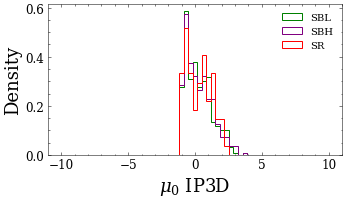

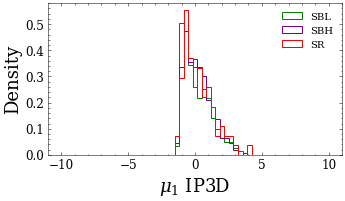

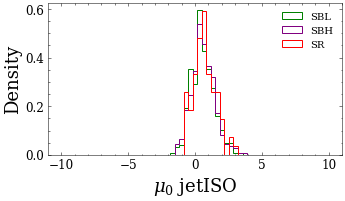

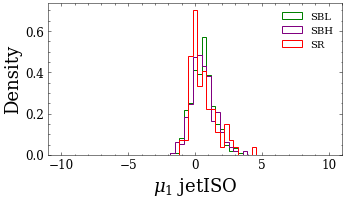

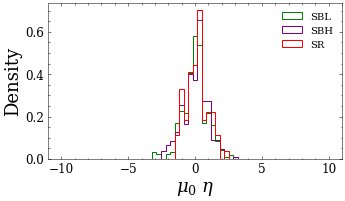

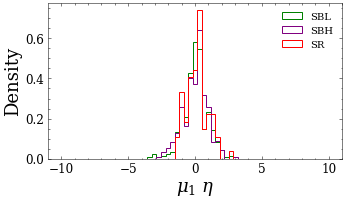

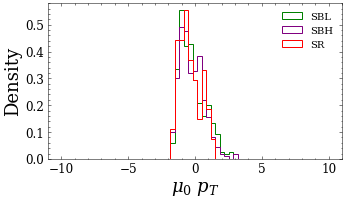

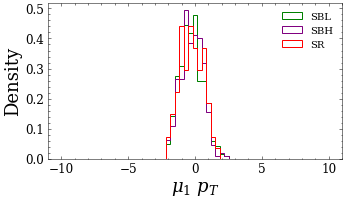

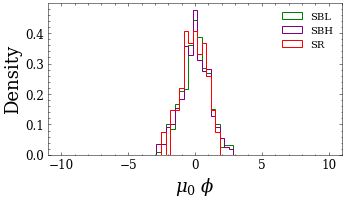

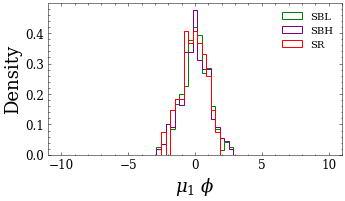

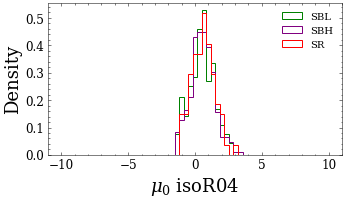

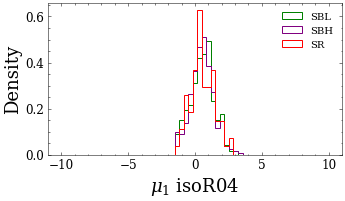

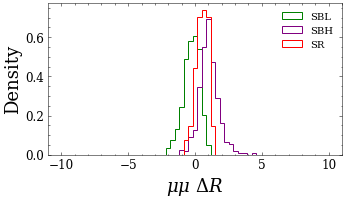

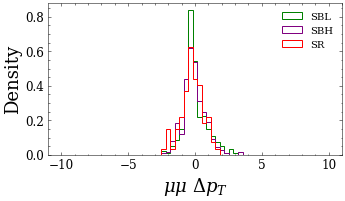

In [12]:
hist_all_features_dict([proccessed_data_dict_OS["SBL"]["s_inj_data"], proccessed_data_dict_OS["SBH"]["s_inj_data"], proccessed_data_dict_OS["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=5, image_path=None, yscale_log=False, nice_labels=True)


hist_all_features_dict([proccessed_data_dict_SS["SBL"]["s_inj_data"], proccessed_data_dict_SS["SBH"]["s_inj_data"], proccessed_data_dict_SS["SR"]["s_inj_data"]], 
                       ["SBL", "SBH", "SR"], feature_set, kwargs_dict_bands, scaled_features=True, plot_bound=10, image_path=None, yscale_log=False, nice_labels=True)





In [13]:
# specify a percentage of events to set aside for the test set

test_data_dict_OS = proccessed_data_dict_OS
test_data_dict_SS = proccessed_data_dict_SS

"""
train_data_dict_OS = {b:{"s_inj_data":{}} for b in bands}
test_data_dict_OS = {b:{"s_inj_data":{}} for b in bands}

train_data_dict_SS = {b:{"s_inj_data":{}} for b in bands}
test_data_dict_SS = {b:{"s_inj_data":{}} for b in bands}


print(sizes_dict)

for b in bands:
    
    random_seed = 4
    
    # make sets for opp sign
    
    # get indices to select
    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])
    
    np.random.seed(random_seed)
    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)
    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)
        
    for feat in feature_set:
 
        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]
        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]
        
    # make sets for same sign
    if particle_type == "eta":
        loc_num_test_events_samesign = np.int((2000/N_total_events_samesign)*sizes_dict_samesign[b])
    elif particle_type == "rho":
        loc_num_test_events_samesign = np.int((10/N_total_events_samesign)*sizes_dict_samesign[b])
    else:
        loc_num_test_events_samesign = np.int((N_test/N_total_events_samesign)*sizes_dict_samesign[b])
    
    np.random.seed(random_seed)
    test_set_inds_samesign = np.random.choice(range(sizes_dict_samesign[b]), size = loc_num_test_events_samesign, replace = False)
    train_set_inds_samesign = np.setdiff1d(list(range(sizes_dict_samesign[b])),test_set_inds_samesign)
        
    for feat in feature_set:
 
        train_data_dict_samesign[b]["s_inj_data"][feat] = proccessed_data_dict_samesign[b]["s_inj_data"][feat][train_set_inds_samesign]
        test_data_dict_samesign[b]["s_inj_data"][feat] = proccessed_data_dict_samesign[b]["s_inj_data"][feat][test_set_inds_samesign]


test_set_size = test_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size = train_data_dict["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict["SBH"]["s_inj_data"]["dimu_mass"].shape[0]

test_set_size_samesign = test_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + test_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ test_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]
train_set_size_samesign = train_data_dict_samesign["SR"]["s_inj_data"]["dimu_mass"].shape[0] + train_data_dict_samesign["SBL"]["s_inj_data"]["dimu_mass"].shape[0]+ train_data_dict_samesign["SBH"]["s_inj_data"]["dimu_mass"].shape[0]

print(f"{test_set_size} test events (target: {N_test}). {train_set_size} train events")    
print(f"{test_set_size_samesign} samesign test events (target: {N_test}). {train_set_size_samesign} samesign train events")      
"""

'\ntrain_data_dict_OS = {b:{"s_inj_data":{}} for b in bands}\ntest_data_dict_OS = {b:{"s_inj_data":{}} for b in bands}\n\ntrain_data_dict_SS = {b:{"s_inj_data":{}} for b in bands}\ntest_data_dict_SS = {b:{"s_inj_data":{}} for b in bands}\n\n\nprint(sizes_dict)\n\nfor b in bands:\n    \n    random_seed = 4\n    \n    # make sets for opp sign\n    \n    # get indices to select\n    loc_num_test_events = int((N_test/N_total_events)*sizes_dict[b])\n    \n    np.random.seed(random_seed)\n    test_set_inds = np.random.choice(range(sizes_dict[b]), size = loc_num_test_events, replace = False)\n    train_set_inds = np.setdiff1d(list(range(sizes_dict[b])),test_set_inds)\n        \n    for feat in feature_set:\n \n        train_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][train_set_inds]\n        test_data_dict[b]["s_inj_data"][feat] = proccessed_data_dict[b]["s_inj_data"][feat][test_set_inds]\n        \n    # make sets for same sign\n    if particle_type == "eta

In [14]:
trial_test_set = mass_scaler.inverse_transform(np.concatenate((test_data_dict_OS["SBL"]["s_inj_data"]["dimu_mass"], test_data_dict_OS["SBH"]["s_inj_data"]["dimu_mass"], test_data_dict_OS["SR"]["s_inj_data"]["dimu_mass"])))


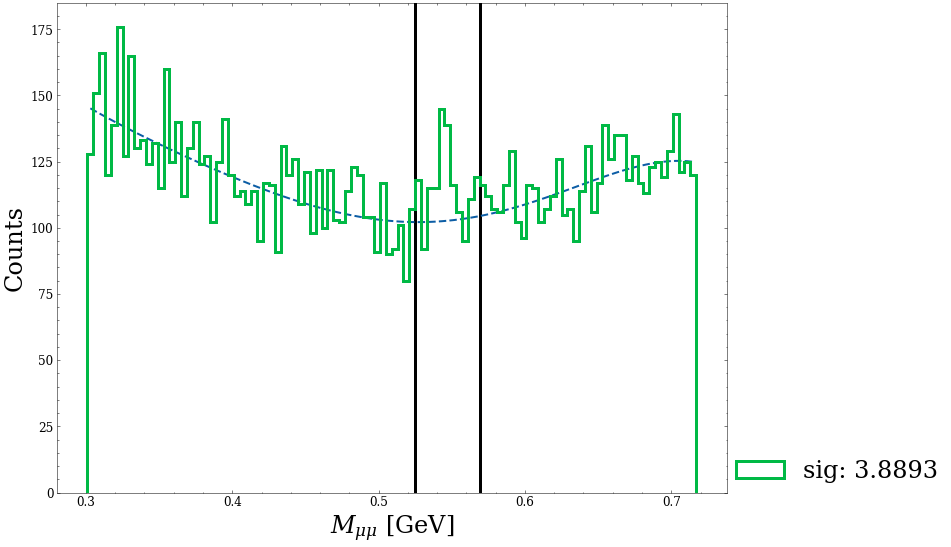

In [15]:
plt.figure(figsize = (12, 9))


# get the fit function to SB background
popt_0, pcov_0, _, _, _ = curve_fit_m_inv(trial_test_set, bkg_fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB, SBL_rescale=None, SBH_rescale=None)
plt.plot(plot_centers_all, bkg_fit_function(plot_centers_all, *popt_0), lw = 2, linestyle = "dashed")    

sig = np.sqrt(calculate_test_statistic(trial_test_set, bkg_fit_function, bkg_fit_type, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt_0, pcov_0))
label_string = "sig: "+str(round(sig,4))
plt.hist(trial_test_set, bins = plot_bins_all, lw = 3, histtype = "step",label = label_string)
    
plt.legend(loc = (1, 0), fontsize = 24)

plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)
plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
plt.ylabel("Counts", fontsize = 24)
plt.show()
    
    

In [16]:

if run_jet:
    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_jet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_jet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict, ofile)



    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_jet_train_band_data", "wb") as ofile:
        pickle.dump(train_data_dict_samesign, ofile)


    with open(f"{working_dir}/projects/{scaler_id}/processed_data/{project_id}_{particle_type}_{analysis_test}_samesign_jet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict_samesign, ofile)

else:


    with open(f"{processed_data_dir}/{project_id}_{particle}_{analysis_test_id}_OS_nojet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict_OS, ofile)



    with open(f"{processed_data_dir}/{project_id}_{particle}_{analysis_test_id}_SS_nojet_test_band_data", "wb") as ofile:
        pickle.dump(test_data_dict_SS, ofile)